<a href="https://colab.research.google.com/github/ritwiks9635/CNN_Project_File/blob/main/Object_Detection_RetinaNet_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Object Detection using RetinaNet**

[Plants 🌿🌳🌲🏡🌳🌲🌴 Dataset](https://www.kaggle.com/datasets/edizaguirre/plants-dataset)

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/edizaguirre/plants-dataset/plants-dataset.zip

Archive:  /content/https:/www.kaggle.com/datasets/edizaguirre/plants-dataset/plants-dataset.zip
  inflating: leaves.tfrecord         
  inflating: leaves_label_map.pbtxt  
  inflating: test_leaves.tfrecord    
  inflating: test_leaves_label_map.pbtxt  


In [ ]:
# Install KerasCV and PyCOCOTools metrics
! pip install -q pycocotools git+https://github.com/keras-team/keras-cv@v0.6.4

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 11.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

print("tensorflow" + tf.__version__)

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
from keras.callbacks import LambdaCallback

print("keras_cv" + keras_cv.__version__)

device_name = tf.test.gpu_device_name()
if "GPU" in device_name:
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU not found.')

tensorflow2.15.0
Using TensorFlow backend
keras_cv0.6.4
Found GPU at: /device:GPU:0


In [ ]:
class_mapping = {
    1: 'Apple Scab Leaf',
    2: 'Apple leaf',
    3: 'Apple rust leaf',
    4: 'Bell_pepper leaf',
    5: 'Bell_pepper leaf spot',
    6: 'Blueberry leaf',
    7: 'Cherry leaf',
    8: 'Corn Gray leaf spot',
    9: 'Corn leaf blight',
    10: 'Corn rust leaf',
    11: 'Peach leaf',
    12: 'Potato leaf',
    13: 'Potato leaf early blight',
    14: 'Potato leaf late blight',
    15: 'Raspberry leaf',
    16: 'Soyabean leaf',
    17: 'Soybean leaf',
    18: 'Squash Powdery mildew leaf',
    19: 'Strawberry leaf',
    20: 'Tomato Early blight leaf',
    21: 'Tomato Septoria leaf spot',
    22: 'Tomato leaf',
    23: 'Tomato leaf bacterial spot',
    24: 'Tomato leaf late blight',
    25: 'Tomato leaf mosaic virus',
    26: 'Tomato leaf yellow virus',
    27: 'Tomato mold leaf',
    28: 'Tomato two spotted spider mites leaf',
    29: 'grape leaf',
    30: 'grape leaf black rot'
}

###**Load and Preprocessing the Dataset**

In [ ]:
train_tfrecord_file = "/content/leaves.tfrecord"
val_tfrecord_file = "/content/test_leaves.tfrecord"

train_dataset = tf.data.TFRecordDataset([train_tfrecord_file])
valid_dataset = tf.data.TFRecordDataset([val_tfrecord_file])

In [ ]:
for record in train_dataset.take(1):
     example = tf.train.Example()
     example.ParseFromString(record.numpy())
     print(example)

In [ ]:
def parse_tfrecord_fn(example):
    feature_description = {
        "image/encoded" : tf.io.FixedLenFeature([], tf.string),
        "image/height" : tf.io.FixedLenFeature([], tf.int64),
        "image/width" : tf.io.FixedLenFeature([], tf.int64),
        "image/object/bbox/xmin" : tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/xmax" : tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/ymin" : tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/ymax" : tf.io.VarLenFeature(tf.float32),
        "image/object/class/label" : tf.io.VarLenFeature(tf.int64)
        }

    parsed_examples = tf.io.parse_single_example(example, feature_description)

    img = tf.image.decode_jpeg(parsed_examples["image/encoded"], channels = 3)
    img = tf.image.convert_image_dtype(img, tf.uint8)

    xmin = tf.sparse.to_dense(parsed_examples['image/object/bbox/xmin'])
    xmax = tf.sparse.to_dense(parsed_examples['image/object/bbox/xmax'])
    ymin = tf.sparse.to_dense(parsed_examples['image/object/bbox/ymin'])
    ymax = tf.sparse.to_dense(parsed_examples['image/object/bbox/ymax'])
    labels = tf.sparse.to_dense(parsed_examples['image/object/class/label'])

    rel_boxes = tf.stack([xmin, ymin, xmax, ymax], axis=-1)
    boxes = keras_cv.bounding_box.convert_format(rel_boxes, source='rel_xyxy', target='xyxy', images=img)

    # Create the final dictionary.
    image_dataset = {
        'images': img,
        'bounding_boxes': {
            'classes': labels,
            'boxes': boxes
        }
    }

    return image_dataset

In [ ]:
train_dataset = train_dataset.map(parse_tfrecord_fn)
valid_dataset = valid_dataset.map(parse_tfrecord_fn)

for i in train_dataset.take(1):
    print(i)

In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

In [ ]:
def visualize_detection(model, dataset, bounding_box_format, rows, cols):
    images, y_true = next(iter(dataset.take(1)))

    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)

    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=rows,
        cols=cols,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

In [ ]:
batch_size = 16
auto = tf.data.experimental.AUTOTUNE
n_rows = 4
n_cols = 4
img_size = 416
bbox_format = "xyxy"

train_dataset = train_dataset.ragged_batch(batch_size).prefetch(buffer_size = auto)
valid_dataset = valid_dataset.ragged_batch(batch_size).prefetch(buffer_size = auto)


data_augmentation = keras.Sequential(
    [
        keras_cv.layers.JitteredResize(
            target_size = (img_size, img_size),
            scale_factor = (0.8, 1.25),
            bounding_box_format = bbox_format
        ),

        keras_cv.layers.RandomFlip(
            mode = "horizontal_and_vertical",
            bounding_box_format = bbox_format
        ),

        keras_cv.layers.RandomSaturation(factor=(0.4, 0.6)),


        keras_cv.layers.RandomHue(factor=0.2, value_range=[0,255])
        ])

val_data_resizing = keras_cv.layers.Resizing(
    img_size, img_size, pad_to_aspect_ratio = True, bounding_box_format = bbox_format)

In [ ]:
train_dataset = train_dataset.map(data_augmentation, num_parallel_calls = tf.data.AUTOTUNE)

valid_dataset = valid_dataset.map(val_data_resizing, num_parallel_calls = tf.data.AUTOTUNE)

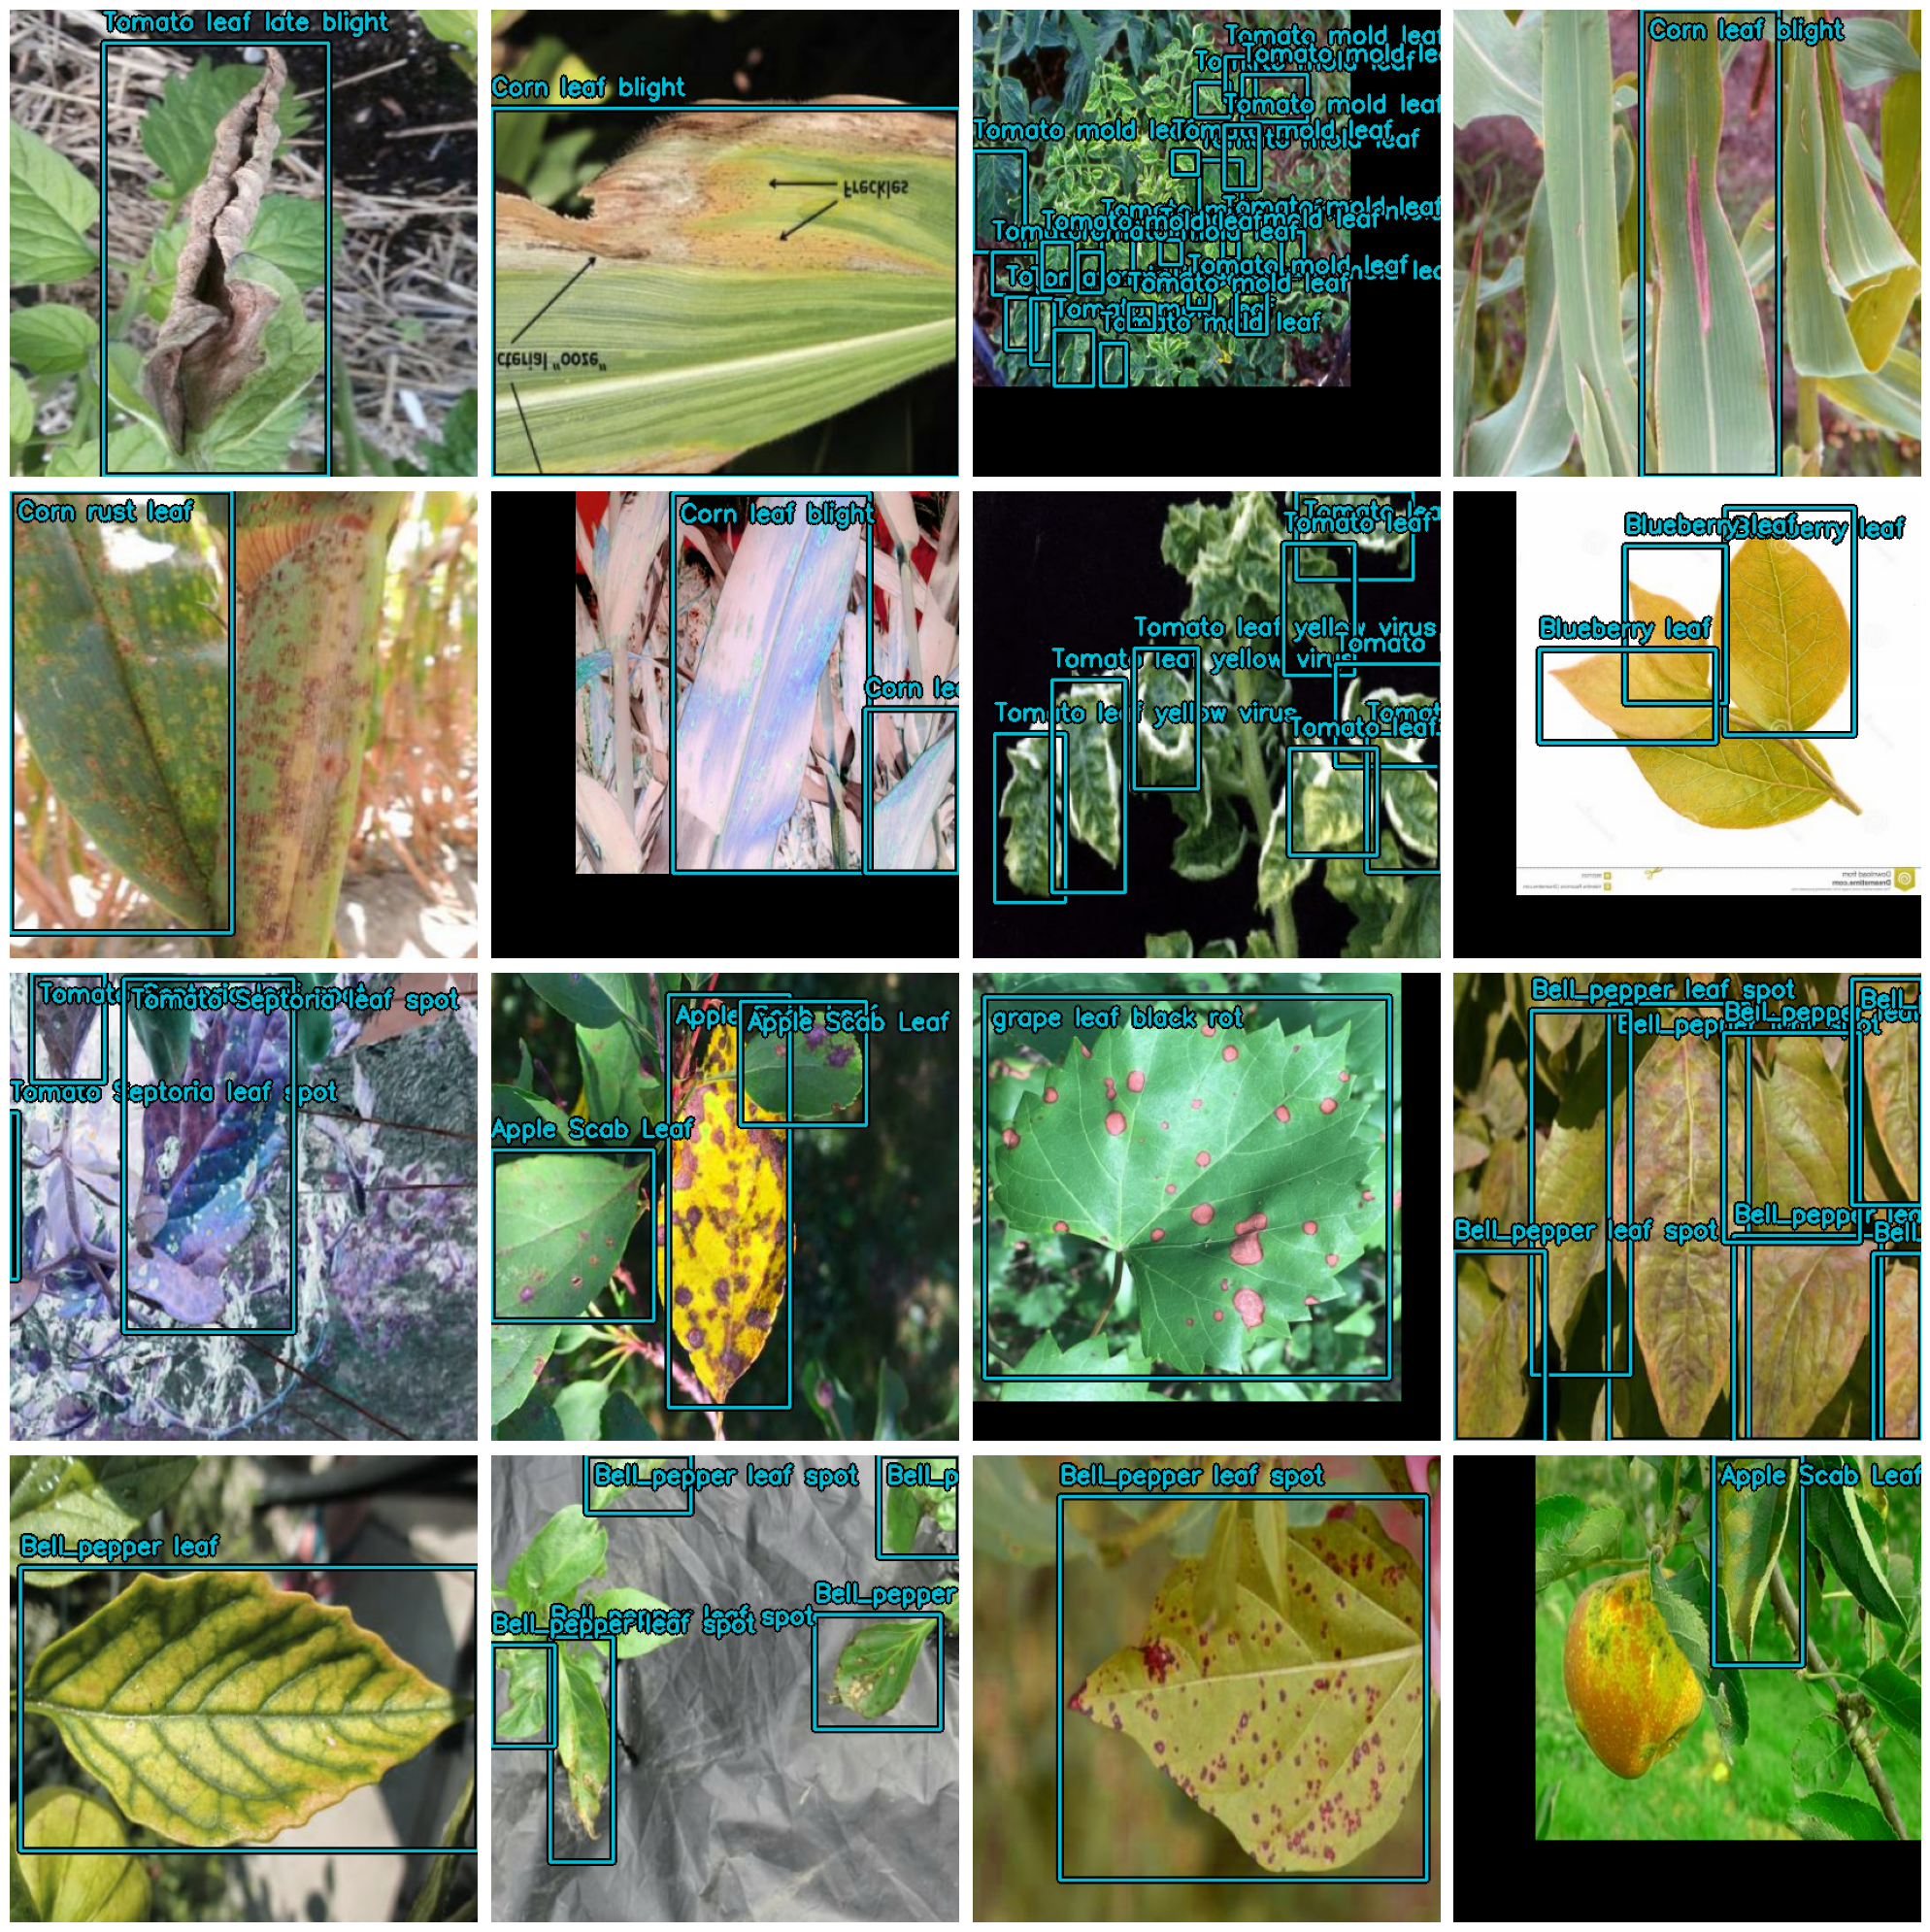

In [ ]:
visualize_dataset(train_dataset, value_range = (0, 255), rows = n_rows, cols = n_cols, bounding_box_format = bbox_format)

In [ ]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32)

In [ ]:
train_dataset = train_dataset.map(dict_to_tuple, num_parallel_calls = tf.data.AUTOTUNE)
valid_dataset = valid_dataset.map(dict_to_tuple, num_parallel_calls = tf.data.AUTOTUNE)

###**Build Model and Prediction**

In [ ]:
def create_model():
    model = keras_cv.models.RetinaNet.from_preset(
        "yolo_v8_m_backbone_coco",
        num_classes = len(class_mapping),
        bounding_box_format = bbox_format)
    return model


optimizer = keras.optimizers.Adam(
    learning_rate = 0.0001,
    global_clipnorm=10.0)

metrics = keras_cv.metrics.BoxCOCOMetrics(
    bounding_box_format = bbox_format, evaluate_freq = 5)

In [ ]:
class VisualizeDetections(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if (epoch+1)%5 == 0:
            visualize_detection(
                self.model, bounding_box_format = bbox_format, dataset = valid_dataset, rows = n_rows, cols = n_cols)


checkpoint_path = "object_detection_model"
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor = "val_loss",
    save_best_only = True,
    save_weights_only = True)


early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 6)


lambda_cb = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs:
        print(f"\nEpoch #{epoch+1} \n" +
              f"Loss: {logs['loss']:.4f} \n" +
              f"mAP: {logs['MaP']:.4f} \n" +
              f"Validation Loss: {logs['val_loss']:.4f} \n" +
              f"Validation mAP: {logs['val_MaP']:.4f} \n")
    )

callbacks = [model_checkpoint, early_stopping_cb, lambda_cb, VisualizeDetections()]

In [ ]:
model = create_model()

# Customizing non-max supression of model prediction.
model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format = bbox_format,
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.5,
)

# Using focal classification loss and smoothl1 box loss with coco metrics
model.compile(
    classification_loss = "focal",
    box_loss = "smoothl1",
    optimizer = optimizer,
    metrics = [metrics]
)


history = model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = 40,
    callbacks = callbacks)

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plotting both training and validation loss
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Create model with the weights of the best model
model.load_weights(checkpoint_path)

# Customizing non-max supression of model prediction. I found these numbers to work fairly well
model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format = bbox_format,
    from_logits = True,
    iou_threshold = 0.2,
    confidence_threshold = 0.6,
)

# Visuaize on test set
visualize_detections(model, dataset = valid_dataset.skip(1), bounding_box_format = bbox_format, rows = n_rows, cols = n_cols)